# Robin Labs Module

In [1]:
# Configure auto-reload
%load_ext autoreload
%autoreload 2

In [2]:
import ipywidgets as widgets
import numpy as np
import os
import seaborn as sns
import warnings
import yaml

from src.robin.labs.entities import RobinLab

from IPython.display import display
from ipywidgets import interact
from matplotlib import pyplot as plt
from pathlib import Path

warnings.simplefilter(action='ignore', category=FutureWarning)

path_config_supply = Path('../configs/ewgt23/supply_data.yml')
path_config_demand = Path('../configs/ewgt23/demand_data.yml')
path_config_labs = Path('../src/robin/labs/config.yml')
tmp_path = Path('../data/labs/tmp')
save_path = Path("../reports/figures/labs")

if not save_path.exists():
    os.mkdir(save_path)

In [3]:
with open(path_config_labs, 'r') as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

supply_options = []
for supply_key, supp_val in config['supply'].items():
    supply_options.append(f'{supply_key.capitalize()}')
        
demand_options = []
for demand_key, dem_val in config['demand'].items():
    demand_options.append(f'{demand_key.capitalize()}')

In [4]:
# Widget to select if we want to perform a supply or demand experiment

widget_opt = widgets.Dropdown(
    options=['Supply', 'Demand'],
    description='Experiment: '
)

# Mostrar el widget
display(widget_opt)

Dropdown(description='Experiment: ', options=('Supply', 'Demand'), value='Supply')

In [5]:
# Set the experiment type and ask for the experiment name

step_widget = widgets.FloatText(value=20, description='Step: ', step=0.5)

# Asumiendo que widget_opt y supply_options ya están definidos
if widget_opt.value.lower() == 'supply':
    # Selecciona qué opción de oferta queremos usar
    widget_supply = widgets.Dropdown(
        options=supply_options,
        description='Supply options:',
        value='Prices'
    )
    
    # Inicializa los widgets de Prices y Capacities con el valor inicial de step
    widget_prices = widgets.IntRangeSlider(
        value=[1, 500],
        min=1,
        max=500,
        step=1,
        description='Prices:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d',
    )
    
    widget_capacities = widgets.IntRangeSlider(
        value=[1, 3],
        min=1,
        max=10,
        step=1,
        description='Capacities:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d',
    )
    
    # Define una función para actualizar el step en los otros widgets cuando cambie step_widget
    def update_step(*args):
        widget_prices.step = step_widget.value
        widget_capacities.step = step_widget.value
    
    # Agrega un observador a step_widget para llamar a update_step cuando cambie su valor
    step_widget.observe(update_step, 'value')
    
    # Define una función para mostrar los widgets apropiados según la opción seleccionada en widget_supply
    def on_supply_change(change):
        if change == 'Prices':
            display(step_widget)
            display(widget_prices)
        elif change == 'Capacities':
            display(step_widget)
            display(widget_capacities)
    
    # Usa interact para llamar a on_supply_change cuando cambie widget_supply
    interact(on_supply_change, change=widget_supply)

else:
    # Select which of the demand options we want to use
    widget_demand = widgets.Dropdown(
        options=demand_options,
        value='demand - 1',
        description='Demand:'
    )
    display(widget_demand)

    # Ask for new config param

interactive(children=(Dropdown(description='Supply options:', index=1, options=('Capacities', 'Prices'), value…

In [6]:
# Update the config file with the new experiment

if widget_opt.value.lower() == 'supply':
    if widget_supply.value.lower() == 'prices':
        config['supply']['prices'] = {'start': widget_prices.value[0], 'stop': widget_prices.value[1], 'step': step_widget.value}
    elif widget_supply.value.lower() == 'capacities':
        pass
else:
    pass 

print("Modified config: ", config)
print("Do you want to save the config?")

update_button = widgets.Button(description="Update Config")
display(update_button) 

def update_config(change):
    with open(path_config_labs, 'w') as f:
        yaml.dump(config, f)
    print("Config updated!")

update_button.on_click(update_config)

Modified config:  {'demand': {'passengers': None}, 'supply': {'capacities': None, 'prices': {'start': 1, 'stop': 500, 'step': 20.0}}}
Do you want to save the config?


Button(description='Update Config', style=ButtonStyle())

## New Robin Lab Experiment

In [7]:
robin_lab = RobinLab(path_config_supply=path_config_supply,
                     path_config_demand=path_config_demand,
                     tmp_path=tmp_path)

In [8]:
robin_lab.set_seed(245)

In [9]:
# Set the configuration for the experiment

robin_lab.set_lab_config(config=config)

  0%|          | 0/25 [00:00<?, ?it/s]

In [10]:
# Move seed to simulate method
robin_lab.simulate(runs=5) # Run simulation

Runs:   0%|          | 0/5 [00:00<?, ?it/s]

Seed used run 0: 131931


Iters:   0%|          | 0/25 [00:00<?, ?it/s]

Seed used run 1: 258375


Iters:   0%|          | 0/25 [00:00<?, ?it/s]

Seed used run 2: 676097


Iters:   0%|          | 0/25 [00:00<?, ?it/s]

Seed used run 3: 881744


Iters:   0%|          | 0/25 [00:00<?, ?it/s]

Seed used run 4: 329667


Iters:   0%|          | 0/25 [00:00<?, ?it/s]

In [21]:
df_markets, df_tickets_sold, df_demand_status = robin_lab.get_sns_dfs()

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

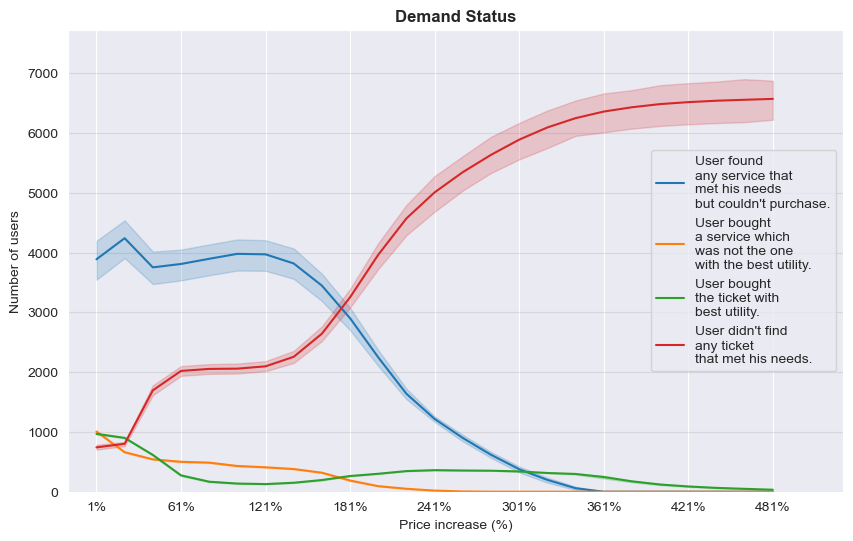

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Demand Status", fontweight='bold')

ax.set_xlim(0, max(df_demand_status["iter"]) * 1.1)
ax.set_ylim(0, max(df_demand_status["users"]) * 1.1)
    
sns.lineplot(ax=ax,
             data=df_demand_status,
             x="iter",
             y="users",
             hue="status")

ax.grid(axis='y', color='#A9A9A9', alpha=0.3, zorder=1)
supply_lab_config = robin_lab.lab_config["supply"]
arange_args = supply_lab_config["prices"]
x_data = np.arange(**arange_args)

ax.set_xticks(ticks=tuple(df_demand_status["iter"].unique())[::3],
              labels=tuple([f"{x:.0f}%" for x in x_data][::3]))
ax.set_xlabel("Price increase (%)")
ax.set_ylabel("Number of users")
ax.legend()

plt.show()
# fig.savefig(save_path, format='svg', dpi=300, bbox_inches='tight', transparent=True)

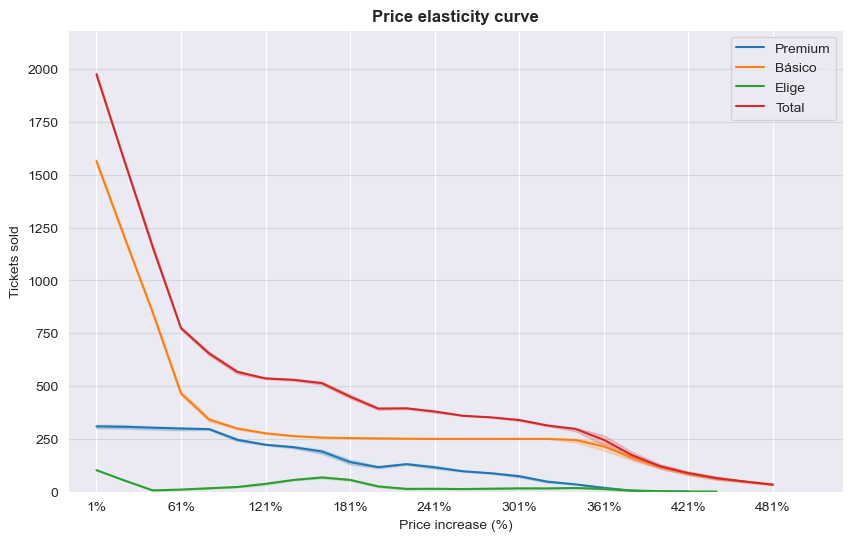

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Price elasticity curve", fontweight='bold')

ax.set_xlim(0, max(df_tickets_sold["iter"]) * 1.1)
ax.set_ylim(0, max(df_tickets_sold["tickets_sold"]) * 1.1)
    
sns.lineplot(ax=ax,
             data=df_tickets_sold,
             x="iter",
             y="tickets_sold",
             hue="seat_type")

ax.grid(axis='y', color='#A9A9A9', alpha=0.3, zorder=1)
supply_lab_config = robin_lab.lab_config["supply"]
arange_args = supply_lab_config["prices"]
x_data = np.arange(**arange_args)

ax.set_xticks(ticks=tuple(df_tickets_sold["iter"].unique())[::3], labels=tuple([f"{x:.0f}%" for x in x_data][::3]))

ax.set_xlabel("Price increase (%)")
ax.set_ylabel("Tickets sold")
ax.legend()

plt.show()
# fig.savefig(save_path, format='svg', dpi=300, bbox_inches='tight', transparent=True)

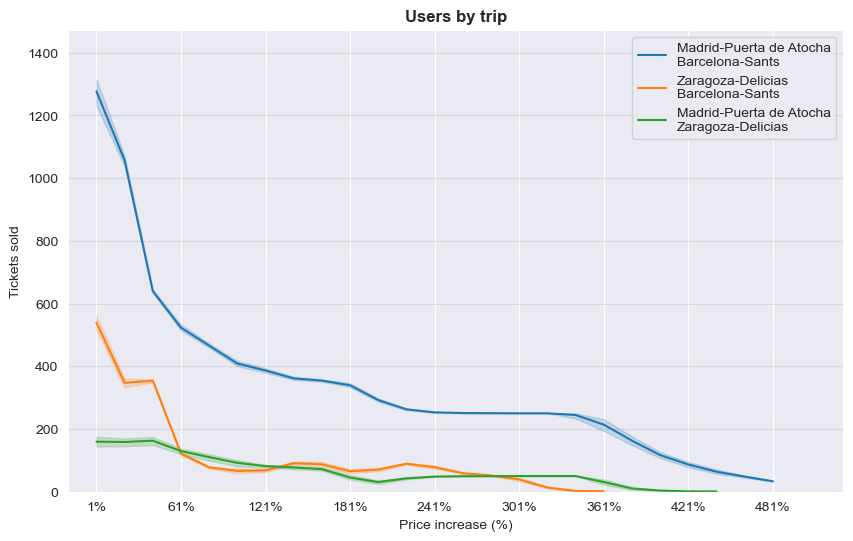

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Users by trip", fontweight='bold')

ax.set_xlim(0, max(df_markets["iter"]) * 1.1)
ax.set_ylim(0, max(df_markets["tickets_sold"]) * 1.1)
    
sns.lineplot(ax=ax,
             data=df_markets,
             x="iter",
             y="tickets_sold",
             hue="trip")

ax.grid(axis='y', color='#A9A9A9', alpha=0.3, zorder=1)
supply_lab_config = robin_lab.lab_config["supply"]
arange_args = supply_lab_config["prices"]
x_data = np.arange(**arange_args)

ax.set_xticks(ticks=tuple(df_tickets_sold["iter"].unique())[::3], labels=tuple([f"{x:.0f}%" for x in x_data][::3]))

ax.set_xlabel("Price increase (%)")
ax.set_ylabel("Tickets sold")
ax.legend()

plt.show()
# fig.savefig(save_path, format='svg', dpi=300, bbox_inches='tight', transparent=True)